<a href="https://colab.research.google.com/github/bndxn/dissertation/blob/main/Model_6_RNN%2C_PV_yield_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
training_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_train.npy')
validation_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_test.npy')

pv_df = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/dissertation/uk_pv/devon_pv_readings.pkl")
pv_df = pv_df.iloc[:,-1] # Only taking the means


In [3]:
print(pv_df.shape)
print(training_sat_times.shape)
print(validation_sat_times.shape)

(233458,)
(24146,)
(10139,)


# Putting PV yield into blocks of 5 readings, per day

In [4]:
# Get the PV data 

def pv_readings_for_sat_times(selected_sat_times, pv_readings_series):

  pv_readings_for_sat_times = []

  for time in selected_sat_times:
    try:
      reading = pv_readings_series[pv_readings_series.index == time][0]
      pv_readings_for_sat_times.append(reading)
    except IndexError:
      pv_readings_for_sat_times.append(0)
  
  pv_readings_for_sat_times = np.asarray(pv_readings_for_sat_times, dtype=object).astype('float32')

  np.nan_to_num(pv_readings_for_sat_times, copy=False)

  print('How many satellite times?', len(selected_sat_times))
  print('How many readings?', len(pv_readings_for_sat_times))
  print('Mean (nan values replaced with zero earlier)', pv_readings_for_sat_times.mean())

  return pv_readings_for_sat_times

train_pv = pv_readings_for_sat_times(training_sat_times, pv_df)
test_pv = pv_readings_for_sat_times(validation_sat_times, pv_df)

How many satellite times? 24146
How many readings? 24146
Mean (nan values replaced with zero earlier) 541.58203
How many satellite times? 10139
How many readings? 10139
Mean (nan values replaced with zero earlier) 600.9855


In [5]:
# Two arrays of training sat times and pv
print(len(training_sat_times), len(train_pv))

# Two arrays of test sat times and pv
print(len(validation_sat_times), len(test_pv))

24146 24146
10139 10139


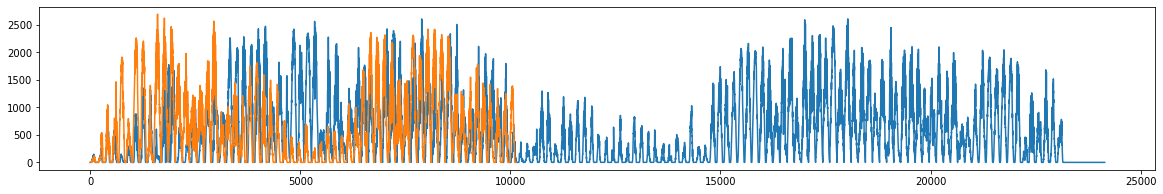

In [8]:
fig = plt.figure(figsize=(20,3))
plt.plot(np.arange(len(train_pv)), train_pv)
plt.plot(np.arange(len(test_pv)), test_pv)

In [14]:
# Now we want to make blocks, one for each day

def get_list_of_days(list_of_timestamps):

  '''
    Takes a list of timestamps, including time
    Returns a list of unique days
  '''

  list_of_days = []

  for i in list_of_timestamps:
    list_of_days.append(pd.Timestamp(i).date())

  return list(dict.fromkeys(list_of_days))


def get_blocks_of_timestamps_for_day(date, list_of_timestamps):

  '''
    Takes a specific date and a list of timestamps (with times)
    Returns a list of blocks of 5 consecutive timestamps for that day
  '''

  timestamps_in_day = []

  # Make a list of all the timestamps for that date
  for i in list_of_timestamps: # Inefficient, checks all timestamps
    if pd.Timestamp(i).date() == date:
      timestamps_in_day.append(i)

  # Work out how many blocks this could make
  blocks_in_day = len(timestamps_in_day) // 5

  block_list = []

  for i in range(blocks_in_day):
    block_list.append(timestamps_in_day[i*5:(i+1)*5])

  return np.asarray(block_list)

def get_pv_reading_blocks(block_list, pv_data, list_of_timestamps):

  '''
    Takes a list of blocks of 5 timestamps
    Returns pv_readings for each of those timestamps
    
    Sat_data and pv_data need to be both for the same set (e.g. both train, or both split)
    because is done based on position, not timestamp
  '''

  pv_readings = np.zeros(shape=(len(block_list), 5)) 

  for i in range(block_list.shape[0]):
    for j in range(block_list.shape[1]):
      timestamp = block_list[i,j]

      index = np.where(list_of_timestamps == timestamp)[0][0]    
      pv_readings[i,j] = pv_data[index] 

  return pv_readings

def bundle_data(list_of_timestamps, pv_data):

  '''
    Combines data sources, using functions above. 
    Iterates through list of days and creates blocks of data for each day
    Concatenates blocks across days
    Returns sat_readings array of blocks, and pv_readings array 
  '''

  list_of_days = get_list_of_days(list_of_timestamps)

  pv_readings_list = []

  for day in list_of_days:

    block_list = get_blocks_of_timestamps_for_day(day, list_of_timestamps)
    pv_readings = get_pv_reading_blocks(block_list, pv_data, list_of_timestamps)
    
    pv_readings_list.append(pv_readings)

    # print('Day :', day)
    # print(sat_readings.shape)
    # print(pv_targets.shape)

  pv_readings = np.concatenate(pv_readings_list)

  return pv_readings

In [34]:
train_blocks = bundle_data(training_sat_times, train_pv)
test_blocks = bundle_data(validation_sat_times, test_pv)


max = np.maximum(np.nanmax(train_blocks), np.nanmax(test_blocks))

train_blocks /= (max+1)
test_blocks /= (max+1)

train_blocks = np.expand_dims(train_blocks, axis=-1)
test_blocks = np.expand_dims(test_blocks, axis=-1)

In [36]:
print(train_blocks.shape)
print(test_blocks.shape)

(4716, 5, 1)
(1980, 5, 1)


In [37]:
x_train, y_train = train_blocks[:,:4], train_blocks[:,-1]
x_test, y_test = test_blocks[:,:4], test_blocks[:,-1]

In [38]:
from sklearn import utils

x_train_shuffle, y_train_shuffle = utils.shuffle(x_train, y_train)
x_test_shuffle, y_test_shuffle = utils.shuffle(x_test, y_test)

In [43]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(1)
])

model.compile(
    loss='mse', optimizer=keras.optimizers.Adam(),
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [76]:
epochs = 20

# Fit the model to the training data

history = model.fit(
    x_train_shuffle,
    y_train_shuffle,
    epochs=epochs,
    validation_data=(x_test_shuffle, y_test_shuffle)
)


Epoch 1/20
148/148 [==============================] - 2s 8ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 2/20
148/148 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/20
148/148 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/20
148/148 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/20
148/148 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/20
148/148 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/20
148/148 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/20
148/148 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/20
148/148 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/20
148/148 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0017

In [48]:
model.predict(x_test[0])[0][0]

0.0062106885

In [49]:
len(x_test)

1980

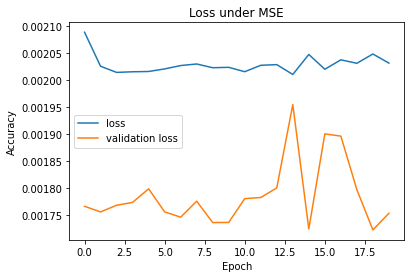

In [81]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Loss under MSE')
plt.legend();

In [78]:
predictions_one = []
predictions_two = []
predictions_three = []
predictions_four = []

for i in range(200):

  prediction_one = model.predict(x_test[i])[0][0]
  predictions_one.append(prediction_one)

  prediction_two = model.predict(x_test[i])[1][0]
  predictions_two.append(prediction_two)

  prediction_three = model.predict(x_test[i])[2][0]
  predictions_three.append(prediction_three)

  prediction_four = model.predict(x_test[i])[3][0]
  predictions_four.append(prediction_four)

predictions_one = np.squeeze(predictions_one)
predictions_two = np.squeeze(predictions_two)
predictions_three = np.squeeze(predictions_three)
predictions_four = np.squeeze(predictions_four)


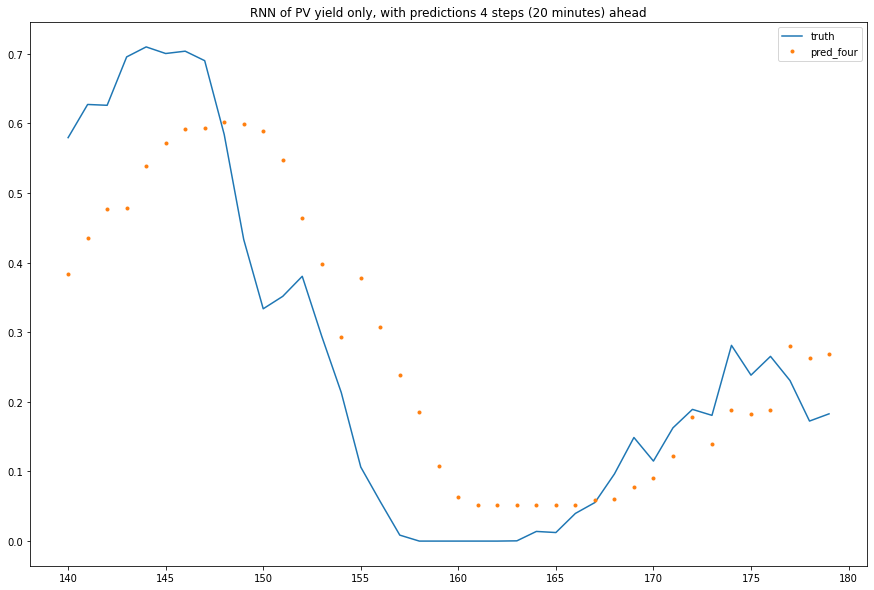

In [82]:
fig = plt.figure(figsize=(15,10))
plt.plot(np.arange(140,180), y_test[143:183], label='truth')
# plt.plot(np.arange(140,180), predictions_one[140:180], '.', label='pred_one')
# plt.plot(np.arange(140,180), predictions_two[140:180], '.', label='pred_two')
# plt.plot(np.arange(140,180), predictions_three[140:180], '.', label='pred_three')
plt.plot(np.arange(140,180), predictions_four[140:180], '.', label='pred_four')
plt.title('RNN of PV yield only, with predictions 4 steps (20 minutes) ahead')
plt.legend();